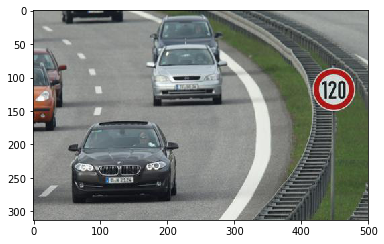

rgb2gray(grayImg):


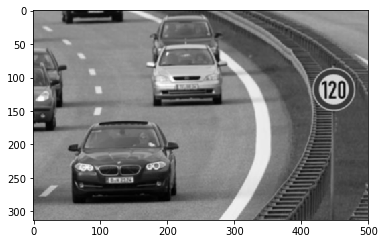

crop_bb:


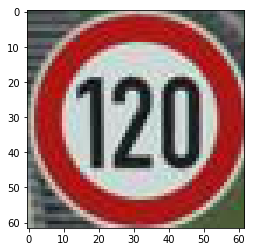

resized_im:


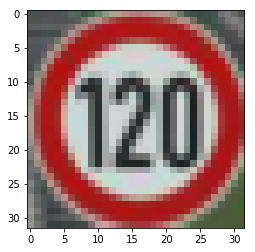

label=[Speed limit (20km/h)] id=0 conf=0.8102703094482422
Draw: label=[Speed limit (20km/h)] id=0 conf=0.8102703094482422
crop_bb:


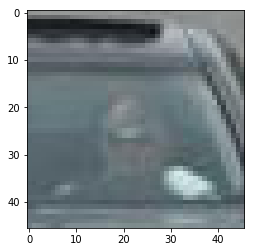

resized_im:


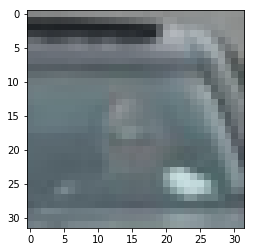

label=[Roundabout mandatory] id=40 conf=0.8947854042053223
No Draw: label=[Roundabout mandatory] id=40 conf=0.8947854042053223


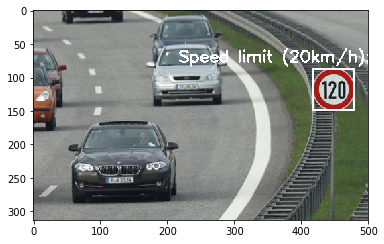

In [4]:
import os
import sys
import cv2
#brew install opencv
#pip install opencv-python
import numpy as np
from pandas import read_csv
#pip install moviepy
#pip install requests
from moviepy.editor import *
from matplotlib import pyplot as plt 
import keras
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import tensorflow as tf
from scipy import misc


infile="../picture/v.mp4"
outfile="../picture/v-output.mp4"

'''
Code adapted from:
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

'''

IMG_SHAPE=[32,32,3]
INPUT_SHAPE=[1,32,32,3]
L2_LAMBDA = 0.0001   
WEIGTHS_PATH="../doc/weights_mltscl_dataaug.hdf5"
OUTPUT_DIM=43
LR = 0.0001
CONF_THRES=0.4

# Labels of circlur signs
cir_cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16,
           17, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42]

signnames = read_csv("../doc/signnames.csv").values[:, 1]

#print(signnames)

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    Ref: https://stackoverflow.com/questions/34968722/softmax-function-python
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def build_mltscl():
    """
    Build multiscale CNN. The last layer must be logits instead of softmax.
    Return a compiled Keras model.
    """

    # Regularization
    l2_reg = keras.regularizers.l2(L2_LAMBDA)

    # Build model
    inpt = keras.layers.Input(shape=IMG_SHAPE)
    conv1 = keras.layers.Convolution2D(
        32, (5, 5), padding='same', activation='relu')(inpt)
    drop1 = keras.layers.Dropout(rate=0.1)(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = keras.layers.Convolution2D(
        64, (5, 5), padding='same', activation='relu')(pool1)
    drop2 = keras.layers.Dropout(rate=0.2)(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = keras.layers.Convolution2D(
        128, (5, 5), padding='same', activation='relu')(pool2)
    drop3 = keras.layers.Dropout(rate=0.3)(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop3)

    pool4 = keras.layers.MaxPooling2D(pool_size=(4, 4))(pool1)
    pool5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(pool2)

    flat1 = keras.layers.Flatten()(pool4)
    flat2 = keras.layers.Flatten()(pool5)
    flat3 = keras.layers.Flatten()(pool3)

    merge = keras.layers.Concatenate(axis=-1)([flat1, flat2, flat3])
    dense1 = keras.layers.Dense(1024, activation='relu',
                                kernel_regularizer=l2_reg)(merge)
    drop4 = keras.layers.Dropout(rate=0.5)(dense1)
    output = keras.layers.Dense(
        OUTPUT_DIM, activation=None, kernel_regularizer=l2_reg)(drop4)
    model = keras.models.Model(inputs=inpt, outputs=output)

    # Specify optimizer
    adam = keras.optimizers.Adam(
        lr=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model=build_mltscl()
model.load_weights(WEIGTHS_PATH)
#model.summary()

def rgb2gray(image):
    """Convert 3-channel RGB image into grayscale"""
    if image.ndim == 3:
        return (0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] +
                0.114 * image[:, :, 2])
    elif image.ndim == 4:
        return (0.299 * image[:, :, :, 0] + 0.587 * image[:, :, :, 1] +
                0.114 * image[:, :, :, 2])

#识别原型的交通牌
def find_circles(img, mg_ratio=0.4, n_circles=1):
    """
    Find circular objects and return bounding boxes in the format
    [x1, y1, x2, y2]
    """
    
    targetImg = np.copy(img)
    
    # Convert to grayscale
    grayImg = np.uint8(rgb2gray(targetImg.copy()))
    
    # Apply Gaussian blur if needed
    #原始值n = 13
    n=3
    grayImg = cv2.GaussianBlur(grayImg.copy(), (n, n), 0)
    
    
    print("rgb2gray(grayImg):")
    plt.imshow(grayImg,cmap=plt.cm.gray)
    plt.show() 
    
    
    #grayImg = targetImg
    # param1 is canny threshold, param2 is circle accumulator threshold
    # Set of parameters for GTSDB testing
    # (because of different frame size and recording device)
    # circles = cv2.HoughCircles(grayImg, cv2.HOUGH_GRADIENT, 1, 200,
    #                            param1=60, param2=50, minRadius=5,
    #                            maxRadius=100)
    
    #通过调节minRadius=20,maxRadius=250设置可以检测的车牌大小
    circles = cv2.HoughCircles(grayImg, cv2.HOUGH_GRADIENT, 1, 200,
                               param1=50, param2=30, minRadius=5,
                               maxRadius=30)

    bboxes = []
    try:
        cir = circles.astype(np.uint16)
        for c in cir[0, :n_circles]:
            r = int(c[2])
            mg = int(r * mg_ratio)
            bboxes.append([c[0] - r - mg, c[1] - r - mg,
                           c[0] + r + mg, c[1] + r + mg])
    except AttributeError:
        pass
    except:
        raise
    return bboxes


def draw_bb(img, bbox, color=(255, 255, 255)):
    """Draw bounding box"""
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                  color, 2)
    return img

def crop_bb(img, bbox):
    """Crop image by specifying bounding box"""
    bb = np.array(bbox)
    bb = bb * (bb > 0)
    return img[bb[1]:bb[3], bb[0]:bb[2], :]


def demo():
    
    demo_file="../picture/traffic_sign.jpg"
    #demo_file="../picture/70.jpg"
    #demo_file="../picture/12_speed_limit_100.jpg"
    demo_img=misc.imread(demo_file, flatten=False, mode='RGB')
    plt.imshow(demo_img) 
    plt.show() 
        
    bboxes = find_circles(demo_img.copy(), mg_ratio=0.1, n_circles=3)
    for bbox in bboxes:
        crop = crop_bb(demo_img.copy(), bbox)
        print("crop_bb:")
        plt.imshow(crop) 
        plt.show() 
        #resized_im = resize(crop)
        resized_im=misc.imresize(crop, (32,32), interp="bilinear")
        resized_im=(resized_im / 255.).astype(np.float32)
        
        print("resized_im:")
        plt.imshow(resized_im) 
        plt.show() 
        
        resized_im=resized_im.reshape(INPUT_SHAPE)
        
        label = np.argmax(model.predict(resized_im)[0])
        conf = np.max(softmax(model.predict(resized_im)[0]))
        # Consider detection only if confidence is larger than threshold
        print("label=[{}] id={} conf={}".format(signnames[label],label,conf))
        if (conf > CONF_THRES ) and  (label in cir_cls) :
            print("Draw: label=[{}] id={} conf={}".format(signnames[label],label,conf))
            demo_img = draw_bb(demo_img, bbox)
            # Put label and confidence
            cv2.putText(demo_img, '{}: {:.2f}'.format(signnames[label], conf), (bbox[0]-200, bbox[1] -10 ),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        else:
            print('No Draw: label=[{}] id={} conf={}'.format(signnames[label],label, conf))

    
    #show_img=np.uint8(show_img * 255)
    plt.imshow(demo_img) 
    plt.show() 
demo()


In [2]:


#实现回调函数 处理每一帧图像
def invert_VideoFileClip(image):
  
    #归一化 非常重要
    show_img=(image.copy() / 255.).astype(np.float32)
    
   
    bboxes = find_circles(show_img, mg_ratio=0.4, n_circles=3)
    for bbox in bboxes:
        
        crop = crop_bb(show_img, bbox)
        
        resized_im=misc.imresize(crop, (32,32), interp="bilinear")
        resized_im=(resized_im / 255.).astype(np.float32)

        resized_im=resized_im.reshape(INPUT_SHAPE)
        
        label = np.argmax(model.predict(resized_im)[0])
        conf = np.max(softmax(model.predict(resized_im)[0]))
        # Consider detection only if confidence is larger than threshold
        print("label=[{}] id={} conf={}".format(signnames[label],label,conf))
        if (conf > CONF_THRES ) and  (label in cir_cls) :
            print("Draw: label=[{}] id={} conf={}".format(signnames[label],label,conf))
            show_img = draw_bb(show_img, bbox)
            # Put label and confidence
            cv2.putText(show_img, '{}: {:.2f}'.format(signnames[label], conf), (bbox[0], bbox[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 1, 0), 2)
            

    show_img=np.uint8(show_img * 255)
    return show_img

#clip = VideoFileClip(infile)
#modifiedClip = clip.fl_image(invert_VideoFileClip)
#modifiedClip.write_videofile(outfile)

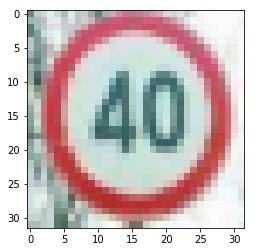

label=[Speed limit (30km/h)] id=1 conf=0.7511886954307556


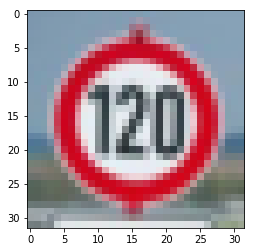

label=[Speed limit (120km/h)] id=8 conf=1.0


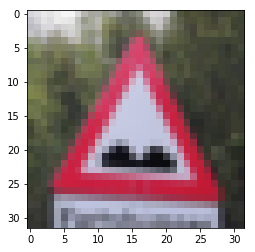

label=[Bumpy road] id=22 conf=1.0


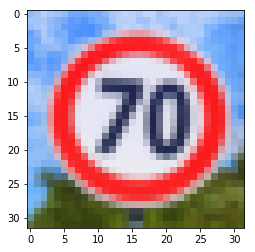

label=[Speed limit (70km/h)] id=4 conf=1.0


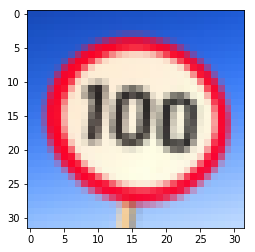

label=[Speed limit (30km/h)] id=1 conf=0.9999966621398926


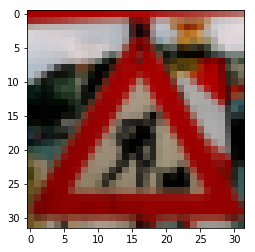

label=[Road work] id=25 conf=1.0


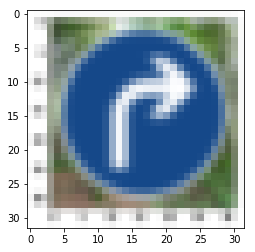

label=[Turn right ahead] id=33 conf=1.0


In [3]:
#测试模型可用性
SAMPLE_IMG_DIR = '../picture/traffic_sign_samples/'

def read_image(im_name):
    """Read a single image into numpy array"""
    return misc.imread(im_name, flatten=False, mode='RGB')

def read_images(path, resize=False, interp='bilinear'):
    """
    Read all image files in a directory, resize to 32 x 32 pixels if
    specified. Return array of images with same format as read from
    load_dataset(). Chosen interpolation algorithm may affect the result
    (default: bilinear). Images are scaled to [0, 1]
    """

    imgs = []
    valid_images = [".jpg", ".gif", ".png", ".tga", ".jpeg", ".ppm"]
    for f in sorted(os.listdir(path)):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        im = read_image(os.path.join(path, f))
        if resize:
            im = misc.imresize(im, (32, 32), interp=interp)
        im = (im / 255.).astype(np.float32)
        imgs.append(im)
    return np.array(imgs)

def test():
    # Load images
    images = read_images(path=SAMPLE_IMG_DIR, resize=True, interp='bilinear')
    for img in images:
        plt.imshow(img)
        plt.show()
        img=img.reshape(INPUT_SHAPE)    
        label = np.argmax(model.predict(img)[0])
        conf = np.max(softmax(model.predict(img)[0]))
        # Consider detection only if confidence is larger than threshold
        print("label=[{}] id={} conf={}".format(signnames[label],label,conf))
 
test()